<a href="https://colab.research.google.com/github/Samin765/DD2430_Project/blob/main/CLIP_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constants
Change these to fit your needs

In [100]:
# path kaggle will download to
HM_DATA_PATH = "/content/drive/MyDrive/dd2430/data/"

# path tourch.save and .load will use
PTH_SAVE_PATH = "/content/drive/MyDrive/dd2430/pth/"

# False if you have already downloaded once
DOWNLOAD_FROM_KAGGLE = False

# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# Imports

In [101]:
import os
import inspect #inspect.getsource(transformers.CLIPProcessor)
import requests
import random

from tqdm import tqdm
from google.colab import files, drive
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import PIL.Image
from PIL import Image, ImageOps

import transformers
from transformers import CLIPModel, CLIPTokenizerFast
from transformers.modeling_outputs import BaseModelOutputWithPooling
from transformers.models.clip.modeling_clip import (
    CLIPTextEmbeddings,
    CLIPEncoder,
    CLIPTextConfig
)

from transformers.modeling_attn_mask_utils import _prepare_4d_attention_mask, _create_4d_causal_attention_mask
from transformers.models.clip.modeling_clip import CLIPOutput, clip_loss

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Download data

In [103]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
if DOWNLOAD_FROM_KAGGLE:
    !pip install kaggle
    files.upload()

    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    %cd HM_DATA_PATH

    !kaggle competitions download -c h-and-m-personalized-fashion-recommendations
    !unzip -q h-and-m-personalized-fashion-recommendations.zip

#Dataset

In [105]:
class HMDataset2(Dataset):
    def __init__(self, articles_csv, image_dir, main_class, processor, model, transform=None):
        # Load the CSV files
        self.articles = pd.read_csv(articles_csv)

        # Image directory
        self.image_dir = image_dir # image folder
        self.processor = processor # prcessor of clip model

        self.transform = transforms.ToTensor()

        # Resize the image and add padding to make it 200x200
        self.transform = transforms.Compose([
            transforms.Resize(200, interpolation=Image.BICUBIC), # Resize the largest side to 200
            transforms.Pad((0, 0, 0, 0), padding_mode='constant'), # Add padding to make it 200x200
            transforms.CenterCrop((200, 200)), # Make sure final size is exactly 200x200
            transforms.ToTensor() # Convert to tensor
        ])

        self.model = model

        self.main_class = main_class #for example prod_name
        self.id_add = 0 # take next if image does not exist
        self.len = self.articles.shape[0]

        self.main_classes = self.articles.columns # all classes
        self.sub_classes = list(self.articles[self.main_class].unique()) # list of all subclasses
        self.count_sub_classes = self.articles[self.main_class].value_counts() # counts in subclasses

        print('Max uniform size:', self.articles[self.main_class].value_counts().min()) # <max uniform size

        self.class_to_id = {name: i for i, name in enumerate(self.sub_classes)}

        self.max_counts = 4 # max number of data per class
        self.counts = {name: 0 for name in self.sub_classes} # number of samples each class

        self.processor.feature_extractor.do_rescale = False # # make sure image values: False=> [0-1] and True=> [0,255]


    def __len__(self):
        return self.len


    def get_n_of_each(self, max_counts):
        """Collects max_counts datapoints from each subclass in large dataset"""
        self.max_counts = max_counts
        all_embeds = []
        all_labels = []
        all_images = []

        for idx in range(self.len):
          id = self.articles['article_id'][idx]
          subclass_name = self.articles[self.main_class][idx]

          if self.counts[subclass_name] < self.max_counts:
              image_path = f"{self.image_dir}/0{str(id)[0:2]}/0{id}.jpg"

              try:
                  # Open the image
                  image = Image.open(image_path)

                  # Resize the image while keeping the aspect ratio
                  image.thumbnail((200, 200), Image.LANCZOS)

                  # Calculate padding to make the image 200x200
                  padding = (200 - image.size[0], 200 - image.size[1])  # Width, Height

                  # Add padding to the image to make it 200x200
                  image = ImageOps.expand(image, (padding[0]//2, padding[1]//2, (padding[0]+1)//2, (padding[1]+1)//2), fill=(0, 0, 0))

                  # Apply any other transforms (in this case, just converting to tensor)
                  image_tensor = self.transform(image)


                  # image_tensor = self.transform(Image.open(image_path))#.to(device)

                  with torch.no_grad():
                      image_embeds, processed_images = get_image_emb(self.model, self.processor, image_tensor)

                  self.counts[subclass_name]+=1
                  all_embeds.append(image_embeds)
                  all_labels.append(subclass_name)
                  all_images.append(processed_images)
              except FileNotFoundError:
                  print(f"Image for article {id} not found. Takes next")

        return torch.cat(all_embeds), all_labels, torch.cat(all_images)



class UniformHMDataset(Dataset):
    """Dataset with perfect class balance"""
    def __init__(self, emb, labels, image):
      self.emb = emb
      self.labels = labels
      self.image = image
      self.classes = list(set(labels))
      self.class_to_id = {name: i for i, name in enumerate(self.classes)}


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        return self.emb[idx], self.labels[idx], self.image[idx]



# Needed to create the dataset
def get_image_emb(model, processor, images):
    """Given an tensor of batch images returns the batch image embeddings [batch, 512]"""

    #print(model.vision_model, processor.image_processor)
    vision_model = model.vision_model # VIT
    image_processor = processor.image_processor # standardise the input
    visual_projection = model.visual_projection # fc layer

    #standardise, same shape as image
    prosessed_images = image_processor(images, return_tensors='pt')['pixel_values']

    # apply VIT snd project to latent space  dim [batch, 768]
    vision_latent = vision_model(prosessed_images.to(model.device))[1] # not same as text

    # project to same dim as text emb by FC layer [batch, 512]
    image_embeds = visual_projection(vision_latent)

    # normalize so norm is one, good for dot product later
    return image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True), prosessed_images

## Create new dataset
This will create a new dataset and save it as a .pth to google drive.

In [106]:
if CREATE_NEW_DATASET:
    dataset = HMDataset2(
        articles_csv = HM_DATA_PATH + 'articles.csv',
        image_dir = HM_DATA_PATH + 'images',
        main_class = 'garment_group_name',
        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device),
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    )

    # data per class
    n_samples = 3

    # you can also set all to n_samples then set the ones you want to 0
    for exclude_subclass in ['Unknown', 'Special Offers', 'some other']:
        dataset.counts[exclude_subclass]=n_samples

    # Create uniform dataset
    image_emb, labels, images = dataset.get_n_of_each(n_samples)

    data_to_save = {
        'image_embedding': image_emb,
        'class_text': labels,
        'images': images,
    }

    os.makedirs(PTH_SAVE_PATH, exist_ok=True)
    torch.save(data_to_save, f'{PTH_SAVE_PATH}HM_data_{n_samples}.pth')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Max uniform size: 908


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Image for article 212042043 not found. Takes next
Image for article 212042066 not found. Takes next


# Load data from Google Drive
If you already have the HM data and .pth saved in google drive, this is where the actual code/program begins.

Remember to change the constants at the top so you don't download and/or create a new dataset next time.

In [107]:
file_to_load = "HM_data_3.pth"

loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')

image_emb = loaded_data['image_embedding']
labels = loaded_data['class_text']
images = loaded_data['images']

dataset = UniformHMDataset(image_emb, labels, images)

<ipython-input-107-cfeb25ab44ed>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')


# Split data into train, test, and val set
Use `dataset_train`, `dataset_test`, and `dataset_val`.

In [108]:
# shuffle the data
combined = list(zip(dataset.emb, dataset.labels, dataset.image))
random.shuffle(combined)
dataset.emb, dataset.labels, dataset.image = zip(*combined)

# split data
data_length = float(len(dataset.labels))
s = lambda t: int(data_length * SET_SIZES[t])

dataset_train = UniformHMDataset(
    dataset.emb[:s("train")],
    dataset.labels[:s("train")],
    dataset.image[:s("train")],
)

dataset_test = UniformHMDataset(
    dataset.emb[s("train"):s("train") + s("test")],
    dataset.labels[s("train"):s("train") + s("test")],
    dataset.image[s("train"):s("train") + s("test")],
)

dataset_val = UniformHMDataset(
    dataset.emb[s("train") + s("test"):],
    dataset.labels[s("train") + s("test"):],
    dataset.image[s("train") + s("test"):],
)

# making sure the spliting worked
print(len(dataset.labels), s("train"), s("test"), s("val"))
print(len(dataset_train.labels), len(dataset_test.labels), len(dataset_val.labels))

57 45 5 5
45 5 7


#Coding

In [109]:
def show_images(X):
    """Given images as tensor shows them"""
    np_images = X.numpy()
    plt.figure(figsize=(10, 10))
    grid_img = torchvision.utils.make_grid(torch.tensor(np_images))
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def return_normal(tensor_image, processor, ant, plot):
    """Reverse normalization and then show image, looks weird otherwise"""
    mean = torch.tensor(processor.feature_extractor.image_mean).view(1, 3, 1, 1)# only colour channels
    std = torch.tensor(processor.feature_extractor.image_std).view(1, 3, 1, 1)
    tensor_image = tensor_image.cpu() * std + mean  # Add back the normalization
    if plot:
      show_images(tensor_image[0:ant,:,:,:])# do not show all
    return tensor_image

In [110]:
def get_text_emb(model, processor, text):
    """Given an tensor of batch text returns the batch text embeddings [batch, 512],
    define X as the number of tokens and might differ from text length"""
    #print(model.text_model, processor.tokenizer)
    text_model = model.text_model # VIT
    text_tokenizer = processor.tokenizer # tokenize the input
    text_projection = model.text_projection # fc layer
    #tokenize, returns 2 tensors, tokens and attention mask [batch, X]
    tokenized_text = text_tokenizer(text, return_tensors='pt', padding=True, truncation = True)
    # apply TRANSFORMER and project to latent space  dim [batch, 512]
    text_latent = text_model(**tokenized_text.to(model.device))[1]
    # project to same dim as text emb by FC layer [batch, 512] unneccessary???
    text_embeds = text_projection(text_latent) #[batch, 512] to [batch, 512] same
    # TODO add LORA
    # normalize so norm is one, good for dot product later
    return text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

def apply_clip(text_embeds, image_embeds, model, train=False):
    """Forward pass of clip"""
    device = model.device # use gpu
    logit_scale = model.logit_scale.exp().to(device) # temperature param
    text_embeds, image_embeds = text_embeds.to(device), image_embeds.to(device)
    # TODO add LORA
    logits_per_image = torch.matmul(image_embeds, text_embeds.t()) * logit_scale
    loss = 0
    if train: # must have same ammount of text as images for training
        loss = clip_loss(logits_per_image.t())
    return logits_per_image, loss

def get_text_emb_soft(model, processor, text, soft_prompt_hidden):
    """Just like get_text_emb but for sof prompts,
    define X as the number of tokens and might differ from text length"""
    #print(model.text_model, processor.tokenizer)
    text_model = model.text_model # VIT original
    text_tokenizer = processor.tokenizer # tokenize the input
    text_projection = model.text_projection # fc layer
    text_embedder_inner = text_model.embeddings # OBS this is the inner embedding NOT the one we want
    # tokenize the text, returns 2 tensors, tokens and attention mask [batch,X+soft]# token len not same as text
    tokenized_text = text_tokenizer(text, return_tensors='pt', padding=True, truncation = True) # returns tokens and attention mask
    # add soft prompt--------------
    # Take out the parts
    input_ids, attention_mask = tokenized_text['input_ids'].to(device), tokenized_text['attention_mask'].to(device)
    attention_mask = attention_mask
    # get only hiddden states, this is before textTransformer is applied
    hidden_states= text_embedder_inner(input_ids) #torch.Size([batch_size, X, 512])
    batch_size = hidden_states.size(0)
    # adding vectors to the embedding torch.Size([4, X+softprompts, 512])
    expand_hidden = soft_prompt_hidden.unsqueeze(0).expand(batch_size, -1, -1)
    hidden_states = torch.cat([expand_hidden.to(device), hidden_states], dim=1)
    # must match the shape
    soft_prompt_attention_mask = torch.ones(batch_size, soft_prompt_hidden.shape[0], dtype=attention_mask.dtype)
    attention_mask = torch.cat([soft_prompt_attention_mask.to(device), attention_mask], dim=1)# just ones
    #end of soft prompt--------------
    # apply costum transformer snd project to latent space  dim [batch, 512]
    text_latent = forward_text(input_ids, attention_mask, hidden_states, text_model)
    # project to same dim as text emb by FC layer [batch, 512] unneccessary???
    text_embeds = text_projection(text_latent) #[batch, 512] to [batch, 512] same
    # TODO add LORA
    # normalize so norm is one, good for dot product later
    return text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)


def forward_text(input_ids, attention_mask, hidden_states, text_model):
    """Modified forward pass of the text model TRANSFORMER to include soft prompts"""
    #print(text_model) # prints the architecture
    num_soft = hidden_states.shape[1]-input_ids.shape[1]
    input_shape = input_ids.size()

    causal_attention_mask = _create_4d_causal_attention_mask((hidden_states.shape[0], hidden_states.shape[1])
    , hidden_states.dtype, device=hidden_states.device)
    if attention_mask is not None and not text_model._use_flash_attention_2:
        attention_mask = _prepare_4d_attention_mask(attention_mask, hidden_states.dtype)

    encoder_outputs = text_model.encoder(
        inputs_embeds=hidden_states,
        attention_mask=attention_mask,
        causal_attention_mask=causal_attention_mask)
    last_hidden_state = encoder_outputs[0]
    last_hidden_state = text_model.final_layer_norm(last_hidden_state)
    last_hidden_state = last_hidden_state[:, num_soft:, :] # remove prompt states
    pooled_output = last_hidden_state[
        torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
        input_ids.view(-1, input_shape[-1]).to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),]
    return pooled_output



# Evaluate

In [111]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [112]:
num_soft_prompts = 3
soft_prompts = nn.Parameter(torch.zeros(num_soft_prompts, model.text_projection.in_features), requires_grad=True)
#randn or zeros
optimizer = torch.optim.Adam([soft_prompts], lr=1e-3) # note that we here specify soft_prompts to tune

criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(dataset, batch_size=40, shuffle=False) # do not shuffle for eval

**Baseline model and untuned softprompt**


obs,compare so that the modified transformer gets same result if num_soft = 0 yes!

  0%|          | 0/2 [00:00<?, ?it/s]

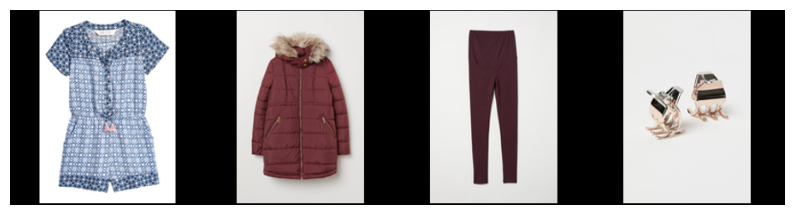

100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

[5, 4, 0, 2, 8, 6, 6, 14, 2, 0, 17, 4, 15, 15, 1, 9, 5, 17, 3, 8, 13, 1, 1, 11, 10, 8, 14, 10, 9, 12, 7, 13, 16, 17, 3, 6, 5, 11, 13, 4, 7, 2, 3, 18, 15, 7, 18, 12, 16, 16, 14, 10, 9, 11, 12, 0, 18]
tensor([ 8, 14, 15,  2,  8,  6,  6, 17,  2, 15,  8, 14, 15, 15, 17, 15,  8,  8,
        15,  8, 13, 15, 17, 16, 16,  8, 17, 15,  9, 12,  8, 13, 16, 17, 17,  6,
         8, 16, 13,  8, 14,  2, 17, 18, 15,  7, 15,  8, 16, 16, 15,  0, 15, 14,
        12, 15,  8])

 Accuracy baseline 42.105262756347656 %
Accuracy Soft prompt untuned 100.0 %


In [115]:
show_image = True
all_predictions_baseline = []
all_predictions_soft_untuned = []
all_labels= []
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader)):
        text = [' '+i for i in dataset.classes] # for prediction
        #text = ['An image of a '+i for i in labels] # for training
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        # baseline
        text_embeds = get_text_emb(model, processor, text)
        logits_per_image1, loss = apply_clip(text_embeds, image_embeds, model)
        probs1 = logits_per_image1.softmax(dim=-1).cpu().numpy()
        # softprompts

        text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)

        logits_per_image2, loss = apply_clip(text_embeds, image_embeds, model)
        probs2 = logits_per_image2.softmax(dim=-1).cpu().numpy()

        if show_image and batch_nr%40==0:
            images = return_normal(images, processor, 4, True)
            #print(dataset.classes)
            #print(probs1.round(decimals=3))
            #print('Base, then soft')
            #print(probs2.round(decimals=3))

        predicted_class_base = logits_per_image1.argmax(dim=-1)
        predicted_class_soft_untuned = logits_per_image2.argmax(dim=-1)

        all_predictions_baseline.append(predicted_class_base)
        all_predictions_soft_untuned.append(predicted_class_soft_untuned)
        for lab in labels:
            all_labels.append(dataset.class_to_id[lab])


all_predictions_baseline=torch.cat(all_predictions_baseline).cpu()
all_predictions_soft_untuned=torch.cat(all_predictions_soft_untuned).cpu()

print(all_labels)
print(all_predictions_baseline)

correct_base = all_predictions_baseline==torch.tensor(all_labels).cpu()
correct_soft_unt = all_predictions_soft_untuned==torch.tensor(all_labels).cpu()
print(f'\n Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')

**Finetuning**

Performance decreases if we add untuned soft prompts, now we finetune

In [114]:
show_image = True
#print(model)#https://github.com/search?q=repo%3Ahuggingface%2Ftransformers%20CLIPModel&type=code
model.train()
loss_list = []
batch_size = 40
epochs = 400
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for batch_nr, (image_embeds, labels, images) in enumerate(dataloader):
        optimizer.zero_grad()
        images.to(model.device)
        #text = ['An image of a '+i for i in dataset.classes] # for prediction, can use what we want
        text = [''+i for i in labels] # for training, must use 1-1 map
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #SLOW
        text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image, loss = apply_clip(text_embeds, image_embeds, model, train=True)
        loss.backward()
        optimizer.step()
        #print(soft_prompts.grad) to see that back prop works, is none otherwise
        running_loss +=loss.item()
    loss_list.append(running_loss)

torch.save(soft_prompts, 'soft_prompts.pth')

 17%|█▋        | 67/400 [00:07<00:35,  9.41it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs+1)), loss_list, label='Training Loss')
# Adding labels and title
plt.title('Training Loss Over Datapoints')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate performance**

In [ ]:
all_labels= []
all_predictions_soft = []
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader)):
        text = [''+i for i in dataset.classes] # for eval
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        #text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)
        text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image2, loss = apply_clip(text_embeds, image_embeds, model)
        predicted_class_soft = logits_per_image2.argmax(dim=-1)
        all_predictions_soft.append(predicted_class_soft)
        for lab in labels:
            all_labels.append(dataset.class_to_id[lab])
all_predictions_soft=torch.cat(all_predictions_soft).cpu()
correct_soft = all_predictions_soft==torch.tensor(all_labels).cpu()

In [ ]:
print(f'\nOf {max(all_labels)} classes random is {1/max(all_labels)}%')
print(f'Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')
print(f'Accuracy Soft prompt {100*correct_soft.sum()/correct_soft.shape[0]} %')
from sklearn.metrics import classification_report
print(classification_report(all_predictions_soft, all_labels))
print(dataset.class_to_id)